Packages

In [1]:
from os import listdir
import matplotlib.pyplot as plt
from imutils import paths
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import tensorflow as tf

Data preparation

In [2]:
# Look at data folder structure
classes_dir = listdir("data/Kather_texture_2016_image_tiles_5000")
classes_dir

['.DS_Store',
 '01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [3]:
# Check files
files = listdir("data/Kather_texture_2016_image_tiles_5000/01_TUMOR")
for n in range(5):
    print(files[n])

10009_CRC-Prim-HE-03_009.tif_Row_301_Col_151.tif
10062_CRC-Prim-HE-02_003b.tif_Row_1_Col_301.tif
100B0_CRC-Prim-HE-09_009.tif_Row_1_Col_301.tif
10104_CRC-Prim-HE-10_021.tif_Row_451_Col_1.tif
10142_CRC-Prim-HE-09_025.tif_Row_151_Col_151.tif


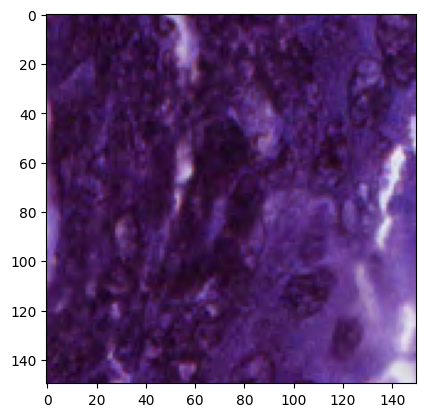

In [5]:
# visualize example image
file = cv2.imread("data/Kather_texture_2016_image_tiles_5000/01_TUMOR/1A11_CRC-Prim-HE-07_022.tif_Row_601_Col_151.tif")
# file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB)
# file = cv2.resize(file, (128, 128))
plt.imshow(file)

In [23]:
# Load data
print("[INFO] loading images...")
imagePaths = list(paths.list_images("data/Kather_texture_2016_image_tiles_5000"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = (imagePath.split(os.path.sep)[-2][1])
    # Since we are going to use MobileNetV2 we need to resize the images
    # to the expected size by the pre-trained network.
    image = load_img(imagePath, target_size=(150, 150))
    image = img_to_array(image)
    image = preprocess_input(image)
    image = tf.cast(image, tf.float32) / 255.0 #normalize
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [5]:
data.shape

(5000, 150, 150, 3)

In [7]:
print(labels[10], labels[2500], labels[4500])

1 5 8


In [43]:
data[0]

array([[[-0.0013687 , -0.00306036, -0.00130719],
        [-0.00081507, -0.00287582, -0.00127643],
        [-0.00081507, -0.00287582, -0.00127643],
        ...,
        [-0.00149173, -0.00321415, -0.00183007],
        [-0.00164552, -0.00336794, -0.00198385],
        [-0.00204537, -0.00333718, -0.00210688]],

       [[-0.00164552, -0.00299885, -0.00149173],
        [-0.00112265, -0.00290657, -0.00139946],
        [-0.00118416, -0.00296809, -0.00146098],
        ...,
        [-0.00096886, -0.00287582, -0.00143022],
        [-0.00139946, -0.00330642, -0.00186082],
        [-0.00213764, -0.00342945, -0.00219915]],

       [[-0.00176855, -0.00284506, -0.00161476],
        [-0.00164552, -0.00293733, -0.00170704],
        [-0.00176855, -0.00306036, -0.00183007],
        ...,
        [-0.00038447, -0.00247597, -0.00096886],
        [-0.0009381 , -0.0030296 , -0.00152249],
        [-0.00192234, -0.00330642, -0.00204537]],

       ...,

       [[-0.00186082, -0.00327566, -0.00213764],
        [-0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


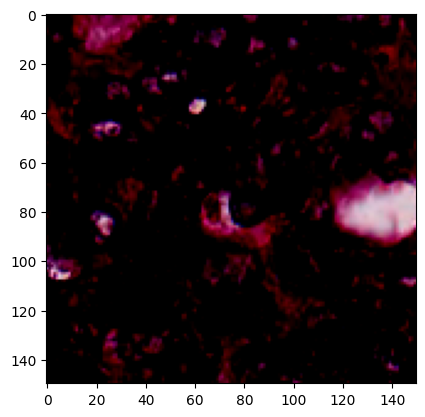

In [41]:
plt.imshow(data[0]*255) # * 255 because of previous normalization

In [24]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# labels = to_categorical(labels)
print(labels[0], labels[0][0], type(labels[0]))

[1 0 0 0 0 0 0 0] 1 <class 'numpy.ndarray'>


In [10]:
print(type(labels[0]))

<class 'numpy.ndarray'>


In [25]:
# Split into train, val, test set
x, x_test, y, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25,train_size =0.75)

Checking shape

In [26]:
print('1- Training set:', x_train.shape, y_train.shape)
print('2- Validation set:', x_val.shape, y_val.shape)
print('3- Testing set:', x_test.shape, y_test.shape)

1- Training set: (3000, 150, 150, 3) (3000, 8)
2- Validation set: (1000, 150, 150, 3) (1000, 8)
3- Testing set: (1000, 150, 150, 3) (1000, 8)


Initial network

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

In [28]:
tf.keras.backend.clear_session()

In [29]:
INIT_LR = 1e-4 # learning rate
EPOCHS = 200
BS = 256

In [30]:
def model_cnn_v1():
    # must define the input shape in the first layer of the neural network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 1, 1, input_shape= (150,150,3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, 3, 3))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(8)) # 1 output value for corresponding class
    model.add(tf.keras.layers.Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy', # categorical_crossentropy for two or more label classes
    optimizer='adam',
    metrics=['accuracy'])
    return model

In [31]:
model=model_cnn_v1()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      128       
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 25, 25, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                    

In [32]:
# initial weights
initial_weights = model.get_weights()
model.set_weights(initial_weights)

In [33]:
# define path to save the mnodel
path_model='model_cnn_v1_large.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=path_model, verbose = 1,save_best_only=True)

In [62]:
history=model.fit(x_train,
                y_train,
                batch_size=BS,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                callbacks=[checkpointer])

Epoch 1/200
12/12 [==============================] - ETA: 0s - loss: 2.0540 - accuracy: 0.2287
Epoch 1: val_loss improved from inf to 1.99229, saving model to model_cnn_v1_large.weights.best.hdf5
12/12 [==============================] - 21s 2s/step - loss: 2.0540 - accuracy: 0.2287 - val_loss: 1.9923 - val_accuracy: 0.2780
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 1.8871 - accuracy: 0.2930
Epoch 2: val_loss improved from 1.99229 to 1.76345, saving model to model_cnn_v1_large.weights.best.hdf5
12/12 [==============================] - 17s 1s/step - loss: 1.8871 - accuracy: 0.2930 - val_loss: 1.7635 - val_accuracy: 0.3000
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 1.6977 - accuracy: 0.2983
Epoch 3: val_loss improved from 1.76345 to 1.58080, saving model to model_cnn_v1_large.weights.best.hdf5
12/12 [==============================] - 17s 1s/step - loss: 1.6977 - accuracy: 0.2983 - val_loss: 1.5808 - val_accuracy: 0.3080
Epoch 4/200
12/12

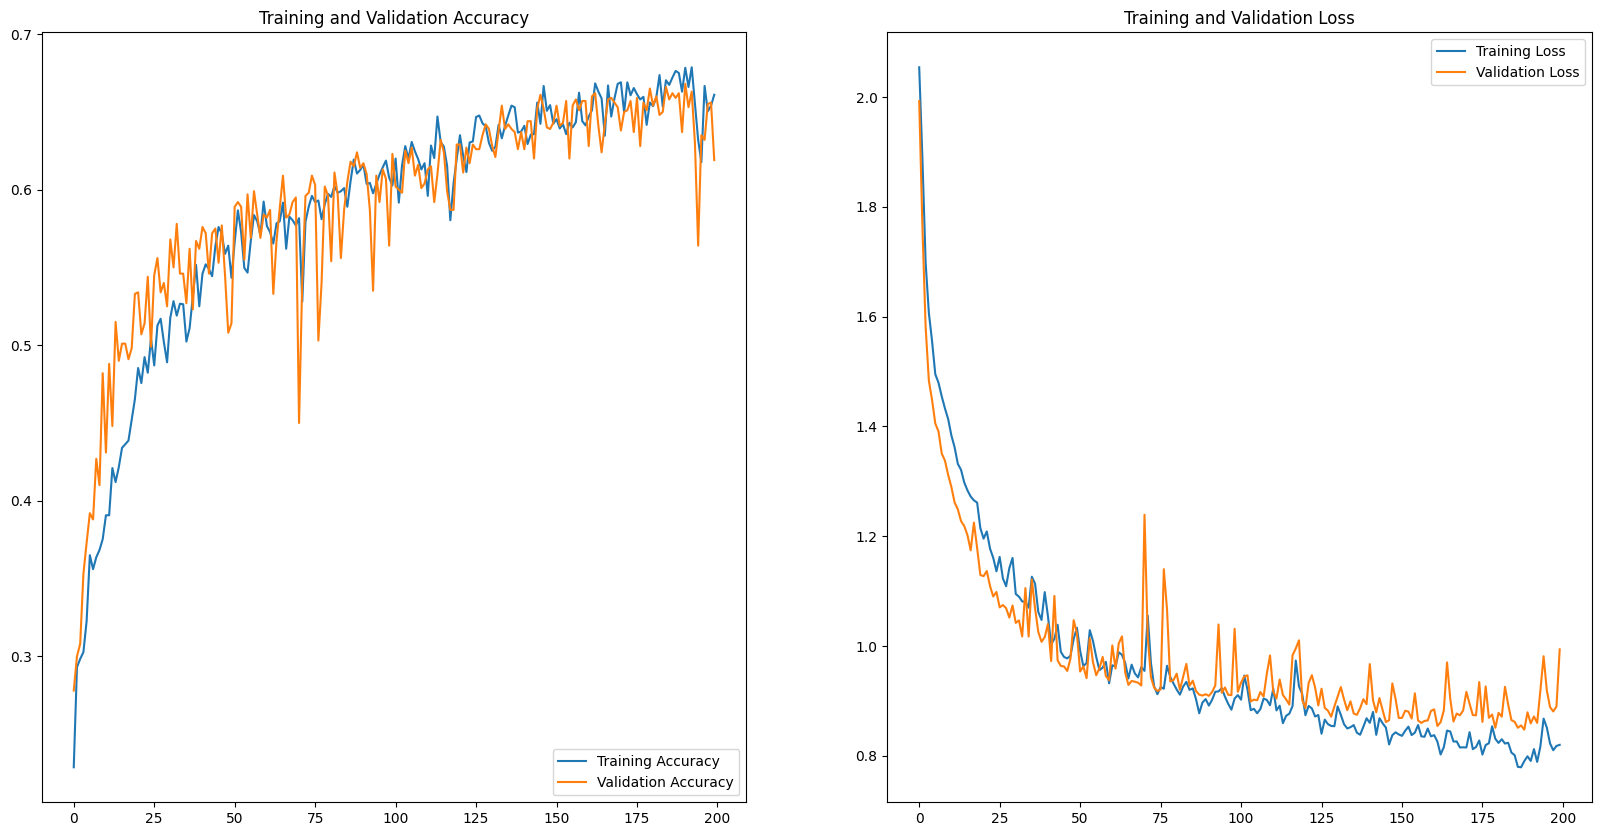

In [63]:
# Visualize accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(200) #adjust epoch range if needed

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [35]:
#clear session
tf.keras.backend.clear_session()
# Model with data augmentation
history2 =model.fit(aug.flow(x_train, y_train, batch_size=BS),
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                callbacks=[checkpointer])

#additionally possible
# steps_per_epoch=len(x_train) // BS,
# validation_steps=len(x_val) // BS,

Epoch 1/200
12/12 [==============================] - ETA: 0s - loss: 2.0408 - accuracy: 0.2137
Epoch 1: val_loss improved from inf to 1.94090, saving model to model_cnn_v1_large.weights.best.hdf5
12/12 [==============================] - 45s 4s/step - loss: 2.0408 - accuracy: 0.2137 - val_loss: 1.9409 - val_accuracy: 0.3090
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 1.8446 - accuracy: 0.2443
Epoch 2: val_loss improved from 1.94090 to 1.66657, saving model to model_cnn_v1_large.weights.best.hdf5
12/12 [==============================] - 52s 4s/step - loss: 1.8446 - accuracy: 0.2443 - val_loss: 1.6666 - val_accuracy: 0.3050
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 1.6673 - accuracy: 0.2820
Epoch 3: val_loss improved from 1.66657 to 1.51882, saving model to model_cnn_v1_large.weights.best.hdf5
12/12 [==============================] - 51s 4s/step - loss: 1.6673 - accuracy: 0.2820 - val_loss: 1.5188 - val_accuracy: 0.3510
Epoch 4/200
12/12

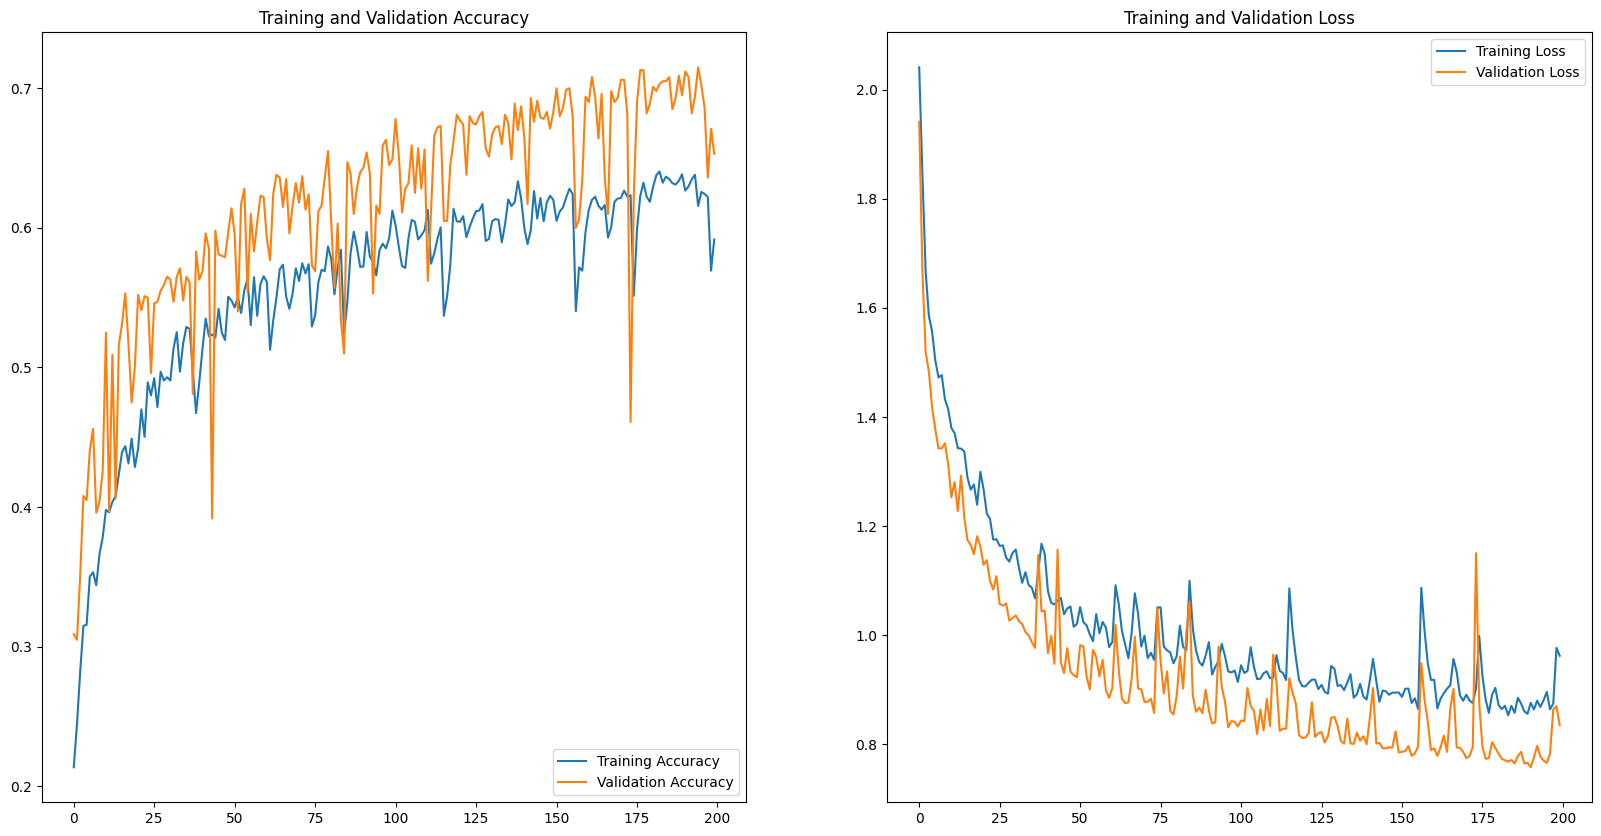

In [36]:
# Visualize accuracy
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(200) #adjust epoch range if needed

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [272]:
# opt = Adam(learning_rate=INIT_LR, weight_decay=INIT_LR / EPOCHS)
# model.compile(loss="binary_crossentropy", optimizer=opt,
#     metrics=["accuracy"])
# H = model.fit(
#     aug.flow(x_train, y_train, batch_size=BS),
#     steps_per_epoch=len(x_train) // BS,
#     validation_data=(x_val, y_val),
#     validation_steps=len(x_val) // BS,
#     epochs=EPOCHS)

In [37]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=BS, verbose=0)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(np.argmax(y_test, axis=1), predIdxs, # labels transformed back to single unit
    target_names=lb.classes_))
model.save("model_cancer_detection_cnn_v1_large", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

           1       0.46      0.10      0.16       123
           2       0.52      0.62      0.57       128
           3       0.58      0.39      0.46       124
           4       0.50      0.85      0.62       118
           5       0.67      0.31      0.42       127
           6       0.49      0.88      0.63       125
           7       0.97      0.93      0.95       127
           8       0.96      1.00      0.98       128

    accuracy                           0.63      1000
   macro avg       0.64      0.63      0.60      1000
weighted avg       0.65      0.63      0.60      1000



In [ ]:
# Precision-recall (PR) curve plots the
# precision = TP / (TP + FP) vs.
# the recall (true-positive rate) = TP / (TP + FN) for various threshold. The higher the better.

In [30]:
predIdxs[0]

7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


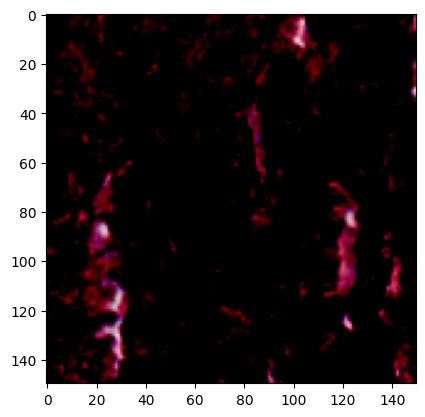

In [38]:
plt.imshow(x_test[0]*255)